## circular_dilation_raw_cells
The purpose of this notebook is to figure out a good way to turn cell centers detected in raw space into more circular looking objects. Since we don't always have isotropic resolution, it should suffice to have cylindrical cells (for now), i.e the z dilation will simply be with a rectangular kernel. 

The tradeoff in doing this is between how circular something needs to appear and the number of pixels you need to do that. We don't want to use too many pixels because we will lose the ability to distinguish between neighboring cells and also will block out the other layers. On the other hand, we need to use enough pixels so that the cells actually look good enough for publication. A plus sign (technically the smallest non trivial pixelized circle) is not good enough, for example. 

In [1]:
import numpy as np
import os
import tifffile as tif
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import ball
from scipy import ndimage
from cloudvolume import CloudVolume
from scipy import signal
%matplotlib inline

## Some example pixelized circles

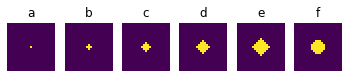

In [17]:
a = np.zeros((25, 25))
a[12, 12] = 1
b=ndimage.binary_dilation(a).astype(a.dtype)
c=ndimage.binary_dilation(b).astype(a.dtype)
d=ndimage.binary_dilation(c).astype(a.dtype)
e=ndimage.binary_dilation(d).astype(a.dtype)
f=e.copy()
f[0:9]=0
f[16:]=0
f[:,0:9]=0
f[:,16:]=0
im_list = [a,b,c,d,e,f]
title_list=['a','b','c','d','e','f']
fig, axs = plt.subplots(1, len(im_list))
for ii in range(len(im_list)):
    axs[ii].imshow(im_list[ii])
    axs[ii].axis('off')
    axs[ii].set_title(title_list[ii])
    

f is the first one that actually looks like a circle. Can use this as a convolution kernel. Can actually make it smaller so there are not so many zeros beyond it. But first let's try to convolve a single z plane of a cell volume with it to see if it works. 

In [2]:
animal_id = 21
pth=os.path.join('/jukebox/wang/Jess/lightsheet_output',
        '201904_ymaze_cfos','processed',f'an{animal_id}','clearmap_cluster_output',
        'cells.npy')

In [3]:
#first, make a map of cells
converted_points = np.load(pth)

In [4]:
x_dim = 2160
y_dim = 2560
z_dim = 687

In [5]:
xyz = np.asarray([(int(xx[0]), int(xx[1]), int(xx[2])) for xx in converted_points]) #cells are counted in horizontal volumes
# init empty vol 
cell_map = np.zeros((z_dim,y_dim,x_dim)).astype('uint16')

In [6]:
#fill map with a single voxel for each coordinate
for x,y,z in xyz:
    try:
        cell_map[z,y,x] = 1 # no dilation yet
    except Exception as e:
        print(e)

In [ ]:
#fill map with a simple z dilation by one pixel on either side
for x,y,z in xyz:
    try:
        cell_map[z-1:z+1,y,x] = 1 #z dilation, but no x or y dilation yet
    except Exception as e:
        print(e)

In [35]:
cell_map.shape # Z Y X 

(687, 2560, 2160)

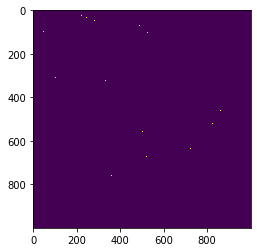

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cell_map[250,1000:2000,1000:2000])

In [9]:
# Now try a manual 3d dilation instead
cell_map_manual = np.zeros((z_dim,y_dim,x_dim)).astype('uint16')

In [61]:
#fill map with a single voxel for each coordinate
for x,y,z in xyz:
    try:
        # The biggest circle occupies z-2:z+3
#         cell_map_manual[z-2:z+3,y-2:y+3,x-3:x+4] = 1 # dilation
#         cell_map_manual[z-2:z+3,y-3,x-2:x+3]=1
#         cell_map_manual[z-2:z+3,y+3,x-2:x+3]=1
#         cell_map_manual[z-2:z+3,y-4,x-1:x+2]=1
#         cell_map_manual[z-2:z+3,y+4,x-1:x+2]=1
#         cell_map_manual[z,y-1:y+2,x-3:x+4] = 1 # dilation
#         cell_map_manual[z,y-2,x-2:x+3]=1
#         cell_map_manual[z,y+2,x-2:x+3]=1
#         cell_map_manual[z,y-3,x-1:x+2]=1
#         cell_map_manual[z,y+3,x-1:x+2]=1
        # Then it is the next smallest circle
        cell_map_manual[z,y-1:y+2,x-2:x+3] = 1 # dilation
        cell_map_manual[z,y-2,x-2:x+3]=1
        cell_map_manual[z,y+2,x-2:x+3]=1
        cell_map_manual[z,y-3,x-1:x+2]=1
        cell_map_manual[z,y+3,x-1:x+2]=1
#         cell_map_manual[z,y-2,x-]
    except Exception as e:
        print(e)

In [43]:
def reset_vol():
    cell_map_manual[cell_map_manual>0]=0
    

In [60]:
reset_vol()

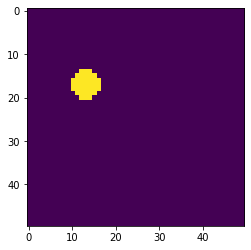

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cell_map_manual[251,1000:1050,1000:1050])

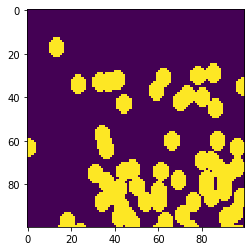

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cell_map_manual[249,1000:1100,1000:1100])

In [ ]:
%%time
# do a simple convolution with the kernel I found above 
conv_im = signal.convolve2d(cell_map[250], f, boundary='symm', mode='same')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(conv_im[1000:1250,1000:1250])

In [ ]:
conv_im[conv_im>1]=1

In [ ]:
new_im=conv_im.astype('uint16')

In [ ]:
new_im.dtype

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(conv_im[1000:1250,1000:1250])

Let's trim down the size of the convolution kernel to see if we can speed up the convolution

In [ ]:
g=f[9:16,9:16]
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(g)

In [ ]:
%%time
conv_im_v2 = signal.convolve2d(cell_map[250], g, boundary='symm', mode='same')

It is about 10 times faster with the smaller kernel!
Can parallelize this over the z planes since each convolution is independent

In [ ]:
output_vol = np.zeros_like(cell_map)

In [ ]:
def dilate_zplane(z):
    print("z plane: ",z)
    output_vol[z] = signal.convolve2d(cell_map[z], g, boundary='symm', mode='same')
    return "success"

In [ ]:
g

In [ ]:
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(max_workers=8) as executor:
    for job in executor.map(dilate_zplane,[250,251,252]):
        try:
            print(job)
        except Exception as exc:
            print(f'generated an exception: {exc}')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cell_map[250])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(output_vol[250])

In [ ]:
output_vol[output_vol>0]

In [ ]:
output_vol[250]=signal.convolve2d(cell_map[250], g, boundary='symm', mode='same')

In [ ]:
from scipy.ndimage import gaussian_filter

result = gaussian_filter(cell_map.astype(float), sigma=2)


In [ ]:
result[result>0.1] = 1
result[result<=0.1] = 0
# result_int = result.astype('uint16')


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(result[150])

In [ ]:
tif.imsave("/home/ahoag/ngdemo/data/registered_cellmap_convolved.tif", result.astype('uint32'))

In [ ]:
# Now create the cloudvolume for this tif file
import os
import numpy as np

from concurrent.futures import ProcessPoolExecutor

from taskqueue import LocalTaskQueue
import igneous.task_creation as tc


from cloudvolume import CloudVolume
from cloudvolume.lib import mkdir, touch
from PIL import Image

In [ ]:
cell_map_filename = "/home/ahoag/ngdemo/data/registered_cellmap_test.tif"
cell_map = tif.imread(cell_map_filename)
cell_map.shape # z,y,x

In [ ]:
home_dir = '/home/ahoag/ngdemo'
progress_dir = mkdir(home_dir + '/label_progress_regcells/')
def make_info_file():
    info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'segmentation', # 'image' or 'segmentation'
        data_type = 'uint16', # can pick any popular uint
        encoding = 'raw', # other options: 'jpeg', 'compressed_segmentation' (req. uint32 or uint64)
        resolution = [ 40000, 40000, 40000 ], # X,Y,Z values in nanometers, 40 microns in each dim
        voxel_offset = [ 0, 0, 1 ], # values X,Y,Z values in voxels
        chunk_size = [ 1024, 1024, 1 ], # rechunk of image X,Y,Z in voxels
        volume_size = [320,528,456], # X,Y,Z size in voxels
    )

    # If you're using amazon or the local file system, you can replace 'gs' with 's3' or 'file'
    vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/demo_dataset/registered_cells', info=info)
    vol.provenance.description = "A demo to show cells registered to the allen atlas"
    vol.provenance.owners = ['ahoag@princeton.edu'] # list of contact email addresses

    vol.commit_info() # generates gs://bucket/dataset/layer/info json file
    vol.commit_provenance() # generates gs://bucket/dataset/layer/provenance json file
    return vol

In [ ]:
def process_slice(z):
    print('Processing slice z=',z)
    
    array = cell_map[z-1].reshape((1,y_dim,x_dim)).T

    cloud_vol[:,:, z] = array
    touch(os.path.join(progress_dir, str(z)))

In [ ]:
 cloud_vol = make_info_file()
""" tifffile is already loaded """
# image = np.array(tifffile.imread(brainvolume_file),dtype=np.uint16, order='F') # F stands for fortran order
z_dim,y_dim,x_dim = cell_map.shape

done_files = set([ int(z) for z in os.listdir(progress_dir) ])
all_files = set(range(cloud_vol.bounds.minpt.z, cloud_vol.bounds.maxpt.z)) # 1 indexed 

to_upload = [ int(z) for z in list(all_files.difference(done_files)) ]
to_upload.sort()
# print("Remaining slices to upload are:",to_upload)

with ProcessPoolExecutor(max_workers=8) as executor:
    executor.map(process_slice, to_upload)

In [ ]:
# make the igenous mesh to display in 3D
def make_mesh():
    # Mesh on 8 cores, use True to use all cores
    cloudpath = cloud_vol.cloudpath
    with LocalTaskQueue(parallel=8) as tq:
      tasks = tc.create_meshing_tasks(cloudpath, mip=0, shape=(256, 256, 256))
      tq.insert_all(tasks)
      tasks = tc.create_mesh_manifest_tasks(cloudpath)
      tq.insert_all(tasks)
    print("Done!")

In [ ]:
make_mesh()

In [ ]:
# Start a viewer and see what it looks like
import neuroglancer
from collections import OrderedDict
neuroglancer.set_static_content_source(url='https://neuromancer-seung-import.appspot.com')

In [ ]:
# First need to host the cloudvolume -- did that in the terminal at port 1337

In [ ]:
viewer = neuroglancer.Viewer()
# This volume handle can be used to notify the viewer that the data has changed.

with viewer.txn() as s:
    s.layers['segmentation'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1337'
    )

#     s.layers[0]._json_data['segments']=unique_segments
print(viewer)

I loaded the allen atlas on there as well and it looks like the atlas is offset in z by a few hundred planes. Let's look at the allen atlas info file to see what is going on

In [ ]:
allen_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/allenatlas/')

In [ ]:
allen_vol.info

Yeah, looks like the x and z dimensions are swapped. Just remake the allen atlas with the correct dimensions and it should be fine. 

In [ ]:
ss = neuroglancer.ScreenshotSaver(viewer, '/home/ahoag/ngdemo/screenshots/')
ss.capture()  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pymrt
# import pymrt.geometry
%matplotlib inline
# A = np.random.rand(10,5,5)
# for Ai in A:
#     plt.imshow(Ai)
#     plt.show()

ModuleNotFoundError: No module named 'pymrt.geometry'

In [5]:
arr = pymrt.sphere(3, 1)

AttributeError: module 'pymrt' has no attribute 'sphere'

In [6]:
import raster_geometry

In [7]:
raster_geometry.sphere?

In [27]:
sphere=raster_geometry.sphere(8,3)
sphere

array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True,  True, False, False, False],
        [False, False,  True,  True,  True,  True, False, False],
        [False, False,  True,  True,  True,  True, False, False],
        [False, False, False,  True,  True, False, False, False],
        [False, False, False, False, False, False, False, False],
        

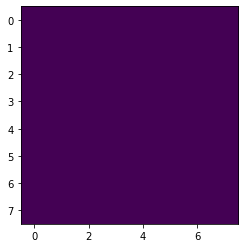

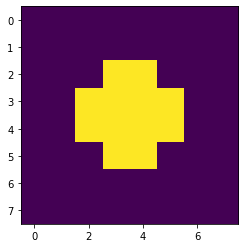

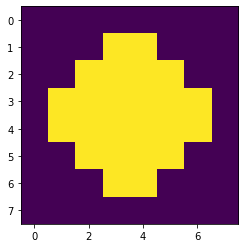

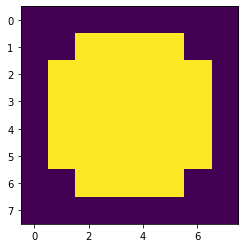

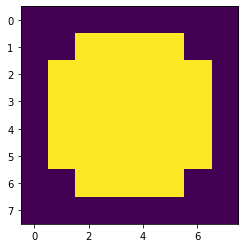

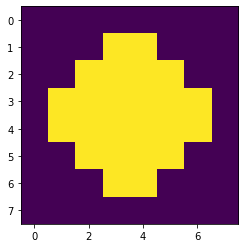

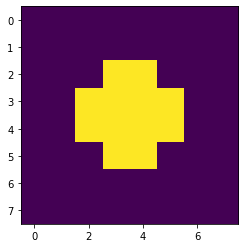

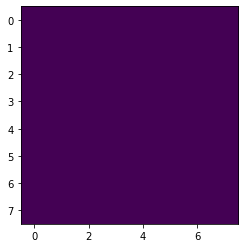

In [28]:
for plane in sphere:
    plt.imshow(plane)
    plt.show()

## 3d convolution over sub-volume of cells

In [45]:
subvol = cell_map[0:350,500:850,500:850]

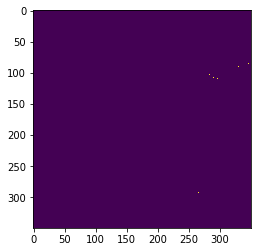

In [46]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(subvol[120])

In [47]:
subvol.shape

(350, 350, 350)

In [63]:
sphere.astype('uint8')

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        

In [48]:
conv_subvol=signal.fftconvolve(subvol, sphere, mode='same')

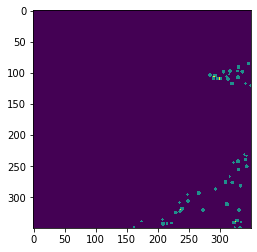

In [64]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(conv_subvol[120,:,:])

In [59]:
from scipy.ndimage.morphology import binary_dilation

In [60]:
a = np.zeros((5, 5))
a[2,2]=1
b=binary_dilation(a)

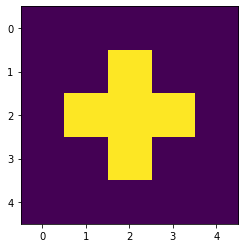

In [61]:
plt.imshow(b)

In [66]:
from skimage.morphology import ball

In [73]:
selem = ball(radius=4)

In [74]:
conv_im4=ndimage.binary_dilation(subvol, structure=selem)

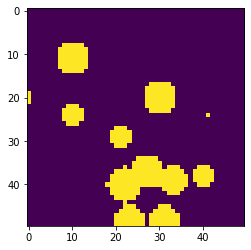

In [75]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(conv_im4[120,300:,300:])

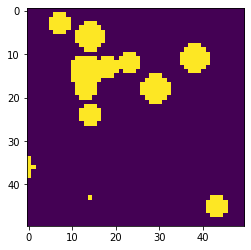

In [76]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(conv_im4[130,300:,300:])